In [ ]:
# Klaudia Dikunow
# 20.12.2020
# Data source: https://www.kaggle.com/c/nlp-getting-started/data

## 1. Libraries import

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon, LineString, GeometryCollection
import math
import seaborn as sns
from matplotlib import font_manager as fm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
import nltk
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score

In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\klaud\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\klaud\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## 2. Reading the data

In [3]:
df = pd.read_csv('D:/kaggle/Real or Not NLP/nlp-getting-started/train.csv')

In [4]:
df_test = pd.read_csv('D:/kaggle/Real or Not NLP/nlp-getting-started/test.csv')

## 3. Basic Explanatory Analysis

In [6]:
df.shape

(7613, 6)

In [7]:
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

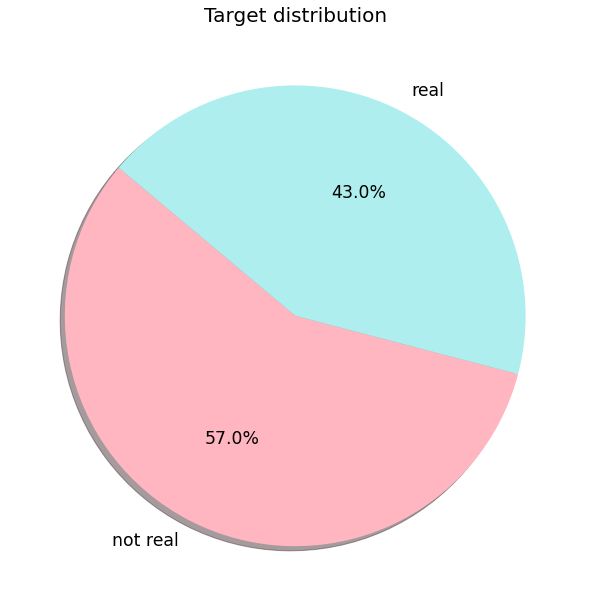

In [9]:
fig = plt.figure(1, figsize=(10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.title('Target distribution', fontsize=20)

patches, texts, autotexts = ax.pie(df['target'].value_counts(), labels=['not real', 'real'], autopct='%1.1f%%',
                                  shadow=True, startangle=140, colors=['lightpink', 'paleturquoise'])

proptease = fm.FontProperties()
proptease.set_size('xx-large')
plt.setp(autotexts, fontproperties=proptease)
plt.setp(texts, fontproperties=proptease)

plt.show()

## 4. Feature engineering

#### Location to country

In [5]:
df['country'] = np.where(df['location'].isin(['USA', 'New York', 'United States', 'Los Angeles, CA', 'Washington, DC',
                                             'Chicago, IL', 'California', 'California, USA', 'San Francisco',
                                             'Florida', 'Los Angeles', 'Washington, D.C.', 'NYC',
                                             'Chicago', 'Seattle', 'Texas', 'US', 'Atlanta, GA', 'New York, NY',
                                             'San Francisco, CA', 'Sacramento, CA', 'Dallas, TX', 'San Diego, CA',
                                             'Nashville, TN', 'Denver, Colorado', 'Pennsylvania, USA','New York City',
                                              'Houston, TX', 'Memphis, TN', 'Tennessee', 'Seattle, WA', 'Austin, TX',
                                              'Denver, CO', 'California, United States', 'Colorado', 'Charlotte, NC',
                                              'Massachusetts', 'San Jose, CA', 'Portland, OR', 'Brooklyn, NY', 
                                             'Oklahoma City, OK', 'Paterson, New Jersey', 'Atlanta',
                                             'Orlando, FL', 'Paterson, New Jersey', 'Cleveland, OH', 'North Carolina',
                                             'Pennsylvania', 'NY', 'New Jersey', 'Paterson, New Jersey',
                                             'Boston, MA', 'Southern California', 'Asheville, NC', 'Texas, USA',
                                             'Wisconsin', 'New York, USA', 'Florida, USA', 'Tampa, FL', 'New Hampshire',
                                             'Indiana', 'Paterson, New Jersey ']), 'USA', 
                         np.where(df['location'].isin(['London', 'UK', 'United Kingdom', 'London, UK',
                                                      'Manchester', 'London, England', 'Leeds, England', 'Newcastle',
                                                      'Coventry', 'Manchester, England', 'london']), 'UK',
                         np.where(df['location'].isin(['Toronto', 'Canada', 'Calgary, Alberta', 'Vancouver, BC', 
                                                       'Calgary, AB', 'canada']), 'Canada',
                         np.where(df['location'].isin(['India', 'Mumbai', 'Mumbai, Maharashtra']), 'India',
                         np.where(df['location'].isin(['Sydney', 'Melbourne, Australia', 
                                                       'Sydney, New South Wales', 'Sydney, Australia']), 'Australia',
                         np.where(df['location'].isin(['Worldwide', 'Earth', 'World', 'worldwide', 'Global',
                                                      'Planet Earth', 'WorldWide']), 'Worldwide',
                         np.where(df['location'].isin(['Morioh, Japan', 'Tokyo']), 'Japan',
                         np.where(df['location'].isin(['Lagos', 'Lagos, Nigeria', 'Port Harcourt, Nigeria', 'Nigeria ']), 'Nigeria',
                         np.where(df['location'].isin(['??????', '304', 'ss', '??', ' Road to the Billionaires Club', 
                                                      'Pedophile hunting ground', 'in the Word of God']), np.nan,
                                
                         df['location'])))))))))

In [7]:
df.head()

,id,keyword,location,text,target,country
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,NaN
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,NaN
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,NaN
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,NaN
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,NaN


## 5. Text mining operations

In [8]:
nlp = spacy.load('en_core_web_sm')

#### Lemmatization

In [9]:
df['text'] = df["text"].apply(lambda row: " ".join([w.lemma_ for w in nlp(row)]) if (row != None) else '')

#### Word count

In [10]:
def word_count(string):
    words = string.split()
    return len(words)

In [11]:
df['word_num'] = df['text'].apply(word_count)

#### Avg word length

In [12]:
def avg_word_length(x):
    words = x.split()
    word_lengths = [len(word) for word in words]
    avg_word_length = sum(word_lengths)/len(words)
    return avg_word_length

In [13]:
df['avg_word_len'] = df['text'].apply(avg_word_length)

#### Hashtaghs

In [14]:
def has_hashtag(x):
    if '#' in x:
        return 1
    else:
        return 0

In [15]:
df['has_hashtag'] = df['text'].apply(has_hashtag)

#### Non-alphanumeric chars

In [16]:
def nonalpha_count(x):
    lemmas = [token.lemma_ for token in nlp(x)]
    lemmas2 = [lemma for lemma in lemmas if lemma.isalpha() or lemma == '-PRON-']
    return len(lemmas) - len(lemmas2)

In [17]:
df['nonalpha_count'] = df['text'].apply(nonalpha_count)

#### POS tag for keywords

In [19]:
def pos_tag(x):
    if pd.isna(x) == False:
        return nltk.pos_tag(x.split())[0][1]

In [20]:
df['keyword_pos'] = df['keyword'].apply(pos_tag)

#### Train test split

In [21]:
df_train, df_test=train_test_split(df,test_size=0.3,random_state=21, stratify = df['target'])

In [22]:
df_train = df_train.reset_index()

In [23]:
df_test = df_test.reset_index()

#### TF-IDF transformation

In [24]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english',  token_pattern = r'[A-Za-z]\w+', ngram_range=(1,3),
                                   min_df = 0.01)

In [25]:
tfidf = tfidf_vectorizer.fit_transform(df_train['text'])

In [26]:
df_tfidf = pd.DataFrame(tfidf.A, columns = tfidf_vectorizer.get_feature_names())

In [27]:
tfidf_test = tfidf_vectorizer.transform(df_test['text'])

In [28]:
df_tfidf_test = pd.DataFrame(tfidf_test.A, columns = tfidf_vectorizer.get_feature_names())

#### Checking for correlations between text variables

In [29]:
bazaCorr=df_tfidf.corr(method='pearson').dropna(how='all',axis=1).dropna(how='all',axis=0)
bazaCorr

,accident,amp,attack,bad,bag,big,body,bomb,building,burn,...,want,war,watch,way,weapon,work,world,wreck,year,youtube
accident,1.000000,-0.011666,-0.013424,-0.010476,-0.011087,-0.011130,-0.014825,-0.015017,-0.013759,-0.015090,...,-0.012468,0.003424,-0.012428,0.006191,-0.010291,-0.013545,-0.012639,0.002361,-0.000300,0.002566
amp,-0.011666,1.000000,-0.004906,-0.016302,-0.009193,-0.018985,-0.016737,-0.020150,-0.002249,0.001627,...,-0.010251,-0.011705,-0.008063,-0.005965,-0.002078,-0.011073,-0.020621,-0.016051,-0.020347,0.016613
attack,-0.013424,-0.004906,1.000000,-0.004476,-0.013357,-0.013409,-0.017861,-0.008776,-0.010693,-0.013371,...,-0.006955,-0.013771,-0.014972,-0.012966,0.010434,-0.016318,0.005017,-0.013445,-0.008264,-0.014716
bad,-0.010476,-0.016302,-0.004476,1.000000,-0.002159,-0.010465,0.000330,-0.009827,-0.012936,-0.006514,...,-0.006555,-0.004430,0.002926,-0.010118,-0.009675,-0.012735,-0.011883,0.009925,0.017308,-0.011484
bag,-0.011087,-0.009193,-0.013357,-0.002159,1.000000,0.004627,0.585769,-0.014942,-0.013690,-0.015014,...,-0.012405,-0.011373,-0.012365,-0.004265,-0.010239,-0.003185,-0.012575,-0.011104,-0.015097,-0.012153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
work,-0.013545,-0.011073,-0.016318,-0.012735,-0.003185,-0.013530,-0.000222,0.047584,-0.006544,0.006817,...,0.049596,0.072362,-0.001823,-0.003114,0.007114,1.000000,-0.000228,-0.006616,0.048090,-0.014848
world,-0.012639,-0.020621,0.005017,-0.011883,-0.012575,-0.003679,-0.016816,0.007703,-0.015607,-0.000276,...,0.011718,0.079745,-0.014096,-0.006539,0.006842,-0.000228,1.000000,-0.000929,-0.017210,-0.013855
wreck,0.002361,-0.016051,-0.013445,0.009925,-0.011104,-0.011147,-0.010082,-0.015040,-0.013780,-0.015113,...,0.004592,-0.011448,0.022795,-0.010779,-0.010306,-0.006616,-0.000929,1.000000,-0.015196,-0.003139
year,-0.000300,-0.020347,-0.008264,0.017308,-0.015097,-0.001673,-0.010728,0.086173,-0.012265,-0.010243,...,-0.013101,0.059196,-0.006115,-0.014655,-0.006501,0.048090,-0.017210,-0.015196,1.000000,-0.016632


In [30]:
correlated = []
correlated_results = []

for j in df_tfidf.columns:
    i = 0
    for x in bazaCorr[j]:
        if j!=bazaCorr[j].index[i] and (x >= 0.7 or x<=-0.7) and [j,bazaCorr[j].index[i]] not in correlated and [bazaCorr[j].index[i],j] not in correlated:         
            correlated.append([j,bazaCorr[j].index[i]])
            correlated_results.append([j,bazaCorr[j].index[i],x])
        i = i+1 

In [31]:
correlated_df = pd.DataFrame(correlated_results, columns=['X','Y','PEARSON_CORR'])
correlated_df.head()

,X,Y,PEARSON_CORR
0,know,pron know,0.715437


In [32]:
correlated_pairs = set(frozenset(p) for p in (correlated))

In [33]:
correlated_to_drop = []
for i in list(correlated_pairs):
    correlated_to_drop.append(list(i)[0])

In [34]:
df_tfidf.drop(correlated_to_drop, axis=1, inplace=True)

In [35]:
df_tfidf_test.drop(correlated_to_drop, axis=1, inplace=True)

In [36]:
df_train = df_train.join(df_tfidf)

In [37]:
df_test = df_test.join(df_tfidf_test)

In [39]:
df_train.head()

,index,id,keyword,location,text,target,country,word_num,avg_word_len,has_hashtag,...,want,war,watch,way,weapon,work,world,wreck,year,youtube
0,5258,7519,oil%20spill,NaN,Hannah : ' Hiroshima sound like -PRON- could b...,1,NaN,24,3.416667,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,5672,8095,rescued,NaN,briton rescue amid Himalaya flood ( http://t.c...,1,NaN,10,9.700000,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,2424,3484,derailed,DC,so a train derail and instead of -PRON- get to...,1,DC,22,3.909091,0,...,0.0,0.0,0.0,0.0,0.0,0.416767,0.0,0.000000,0.0,0.0
3,2179,3123,debris,Seattle,# love # food # fun malaysian Prime Minister N...,1,USA,24,4.875000,1,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,7485,10707,wreck,"Alabama, USA",first wreck today . so so glad -PRON- and mom ...,0,"Alabama, USA",34,2.911765,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.395422,0.0,0.0


In [40]:
to_drop = ['index', 'keyword', 'text']

In [41]:
df_train.drop(to_drop, axis=1, inplace=True)
df_test.drop(to_drop, axis=1, inplace=True)

In [42]:
df_train.shape

(5329, 95)

In [43]:
df_test.shape

(2284, 95)

In [44]:
df_train.head()

,id,location,target,country,word_num,avg_word_len,has_hashtag,nonalpha_count,keyword_pos,accident,...,want,war,watch,way,weapon,work,world,wreck,year,youtube
0,7519,NaN,1,NaN,24,3.416667,0,5,NN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,8095,NaN,1,NaN,10,9.700000,0,5,VBN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,3484,DC,1,DC,22,3.909091,0,0,VBN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.416767,0.0,0.000000,0.0,0.0
3,3123,Seattle,1,USA,24,4.875000,1,7,NN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,10707,"Alabama, USA",0,"Alabama, USA",34,2.911765,0,10,NN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.395422,0.0,0.0


## 6. Missing values

#### Character

In [45]:
chars = list(df_train.select_dtypes(include=['O']).columns)

In [46]:
chars

['location', 'country', 'keyword_pos']

In [47]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [48]:
braki_char = pd.DataFrame(missing_values_table(df_train[chars]))
braki_lista_char = braki_char.loc[braki_char['% of Total Values'] > 0.0 ]

print(braki_lista_char)

Your selected dataframe has 3 columns.
There are 3 columns that have missing values.
             Missing Values  % of Total Values
country                1794               33.7
location               1763               33.1
keyword_pos              37                0.7


In [49]:
df_train['country'] = df_train['country'].fillna('Missing')
df_test['country'] = df_test['country'].fillna('Missing')

df_train['location'] = df_train['location'].fillna('Missing')
df_test['location'] = df_test['location'].fillna('Missing')

df_train['keyword_pos'] = df_train['keyword_pos'].fillna('NN')
df_test['keyword_pos'] = df_test['keyword_pos'].fillna('NN')

#### Numeric

In [50]:
nums = [i for i in df_train.columns if i not in chars and i not in ('id', 'target')]

In [51]:
braki_num = pd.DataFrame(missing_values_table(df_train[nums]))
braki_lista_num = braki_num.loc[braki_num['% of Total Values'] > 0.0 ]

print(braki_lista_num)

Your selected dataframe has 90 columns.
There are 0 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


## 7. Binning character variables

In [52]:
to_dummify = braki_lista_char.index

In [53]:
to_dummify

Index(['country', 'location', 'keyword_pos'], dtype='object')

In [54]:
for i in to_dummify:
    dummy = pd.get_dummies(df_train[i], prefix = i)
    dummy_test = pd.get_dummies(df_test[i], prefix = i)
    if df_train[i].value_counts(sort=True).index[0] not in ('Missing'):
        mask = pd.DataFrame(df_train[i].value_counts(sort=True)).index[0]
    else:
        mask = pd.DataFrame(df_train[i].value_counts(sort=True)).index[1] 
    dummy.drop(i+'_'+mask, inplace=True, axis=1)
    dummy_test.drop(i+'_'+mask, inplace=True, axis=1)
    df_train = pd.concat([df_train,dummy], axis=1)
    df_test = pd.concat([df_test,dummy_test], axis=1)
    df_train.drop(i, inplace=True, axis=1)
    df_test.drop(i, inplace=True, axis=1)

## 8. Variable checks

#### Degenerated variables

In [55]:
bin_col = list()
for i in df_train.columns:
    if (len(df_train[i].value_counts())==2) & (i !='target'):
        bin_col.append(i)

In [57]:
zdegenerowane = []
for col in bin_col:
    x = df_train[col].value_counts() / df_train[col].value_counts().sum()
    if x.iloc[0] <= 0.005 or x.iloc[1] <= 0.005:
        zdegenerowane.append(col)

In [58]:
len(zdegenerowane)

4855

In [59]:
df_train.drop(zdegenerowane, axis=1, inplace=True)

In [60]:
features = df_train.columns

In [61]:
df_test = df_test[features]

In [62]:
df_train.shape

(5329, 108)

In [63]:
df_test.shape

(2284, 108)

In [64]:
df_train.head()

,id,target,word_num,avg_word_len,has_hashtag,nonalpha_count,accident,amp,attack,bad,...,country_Worldwide,location_London,location_Missing,location_New York,location_United States,keyword_pos_JJ,keyword_pos_NNS,keyword_pos_VBD,keyword_pos_VBG,keyword_pos_VBN
0,7519,1,24,3.416667,0,5,0.0,0.0,0.0,0.000000,...,0,0,1,0,0,0,0,0,0,0
1,8095,1,10,9.700000,0,5,0.0,0.0,0.0,0.000000,...,0,0,1,0,0,0,0,0,0,1
2,3484,1,22,3.909091,0,0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,1
3,3123,1,24,4.875000,1,7,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,10707,0,34,2.911765,0,10,0.0,0.0,0.0,0.403869,...,0,0,0,0,0,0,0,0,0,0


#### Variables not differenciating the target variable

In [65]:
bin_col = list()
for i in df_train.columns:
    if (len(df_train[i].value_counts())==2) & (i !='target'):
        bin_col.append(i)

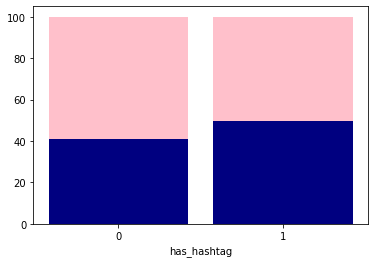

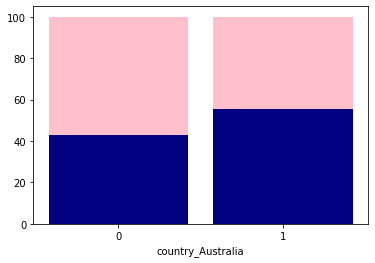

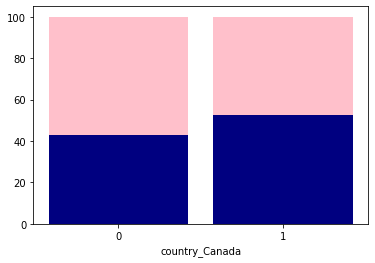

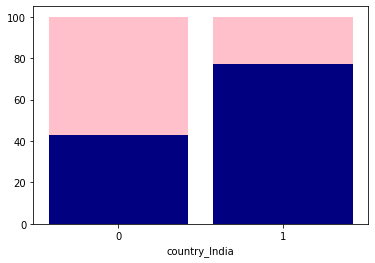

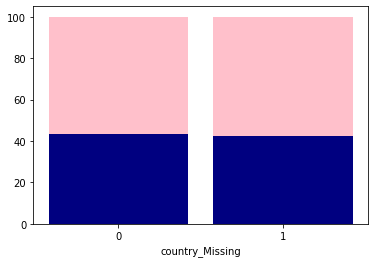

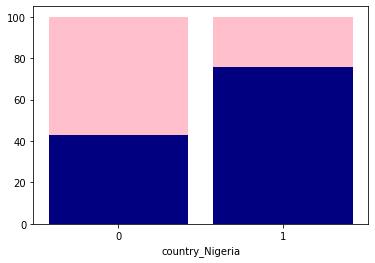

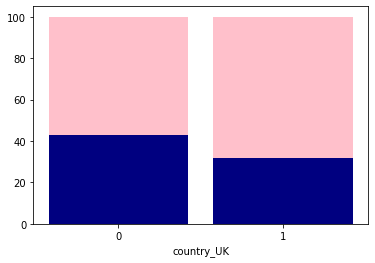

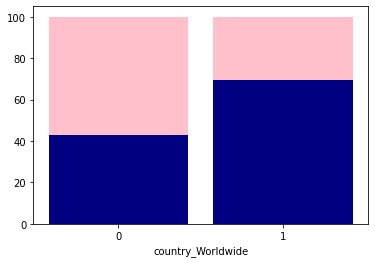

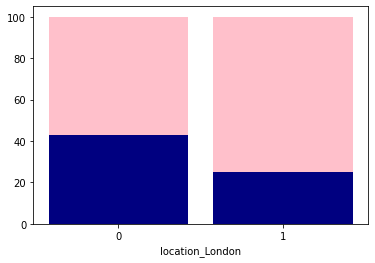

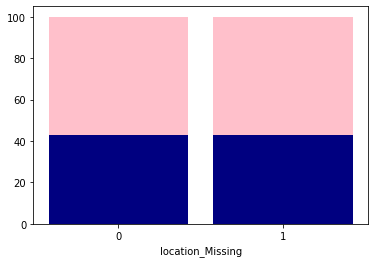

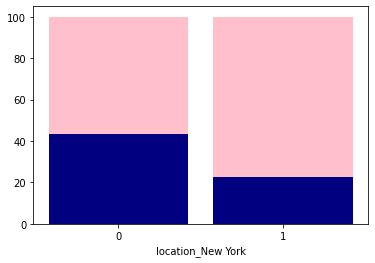

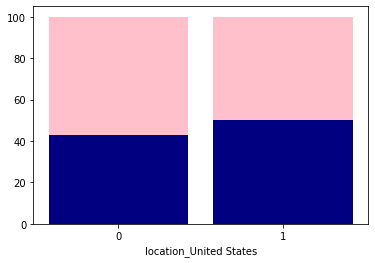

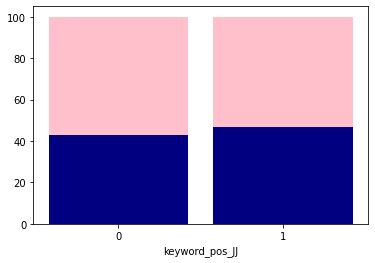

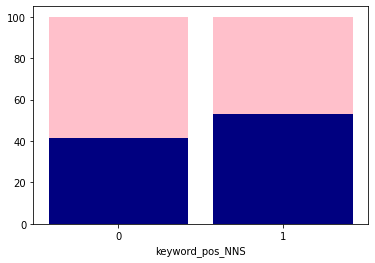

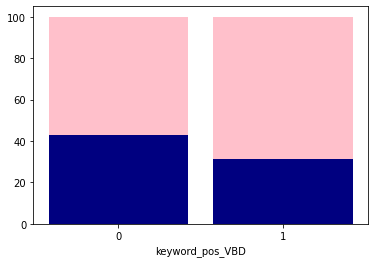

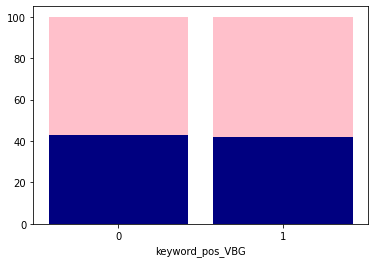

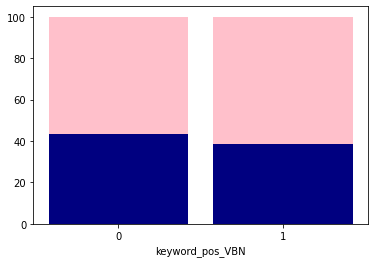

In [66]:
for k in bin_col:
    cross = pd.crosstab(df_train[k], df_train['target'])
    totals = [i+j for i,j in zip(cross[0.0], cross[1.0])]
    target = [i/j * 100 for i,j in zip(cross[1.0],totals)]
    nontarget = [i/j * 100 for i,j in zip(cross[0.0], totals)]
    
    barWidth = 0.85
    names = ('0', '1')
    r =[0,1]
    
    plt.bar(r, target, color='navy', width=barWidth)
    plt.bar(r, nontarget, bottom=target, color='pink', width=barWidth)
    plt.xticks(r, names)
    plt.xlabel(k)
    plt.show()

In [68]:
notdiff =[]
for i in bin_col:
    table=df_train[[i, 'target']].groupby([i], as_index=False).mean().sort_values(by='target', ascending=False)
    diff = 100* (table.loc[0,'target'] - table.loc[1, 'target']) / table.loc[0,'target']
    if abs(diff) <= 10:
        notdiff.append(table.columns[0])

In [69]:
notdiff

['country_Missing', 'location_Missing', 'keyword_pos_JJ', 'keyword_pos_VBG']

In [70]:
df_train.drop(notdiff, axis=1, inplace=True)
df_test.drop(notdiff, axis=1, inplace=True)

#### Checking for correlation with target

In [71]:
kols =[i for i in df_train.columns if i!='id']

In [72]:
bazaCorr=df_train[kols].corr().dropna(how='all',axis=1).dropna(how='all',axis=0)

In [73]:
bazaCorr

,target,word_num,avg_word_len,has_hashtag,nonalpha_count,accident,amp,attack,bad,bag,...,country_India,country_Nigeria,country_UK,country_Worldwide,location_London,location_New York,location_United States,keyword_pos_NNS,keyword_pos_VBD,keyword_pos_VBN
target,1.000000,0.015886,0.163704,0.073336,0.017508,0.065997,-0.017192,0.064675,-0.028707,-0.071006,...,0.053228,0.055239,-0.029566,0.044101,-0.026386,-0.041163,0.011708,0.072921,-0.028871,-0.030114
word_num,0.015886,1.000000,-0.493173,0.159115,0.550442,0.010996,0.191147,-0.004755,0.055843,0.004328,...,0.012998,-0.005276,0.006038,-0.004481,0.026718,0.019008,0.001790,0.058034,-0.017512,0.034766
avg_word_len,0.163704,-0.493173,1.000000,-0.005312,-0.205537,0.000294,-0.092072,0.021040,-0.053808,-0.005752,...,0.000098,0.050651,0.009226,0.041819,-0.011533,0.064114,0.005189,-0.018907,-0.007495,-0.022962
has_hashtag,0.073336,0.159115,-0.005312,1.000000,0.347590,0.010379,0.031175,-0.003633,0.002110,-0.012196,...,-0.006475,0.018941,0.017748,0.014998,0.015962,-0.032144,0.020449,0.015319,-0.006146,-0.024143
nonalpha_count,0.017508,0.550442,-0.205537,0.347590,1.000000,0.007999,0.171963,-0.028335,-0.007014,0.001669,...,0.008147,-0.004153,-0.008907,0.010763,-0.001015,0.051024,0.024108,0.024929,-0.021957,-0.013330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
location_New York,-0.041163,0.019008,0.064114,-0.032144,0.051024,-0.010580,-0.019157,-0.000927,-0.009947,0.115032,...,-0.007667,-0.008381,-0.013211,-0.008266,-0.007284,1.000000,-0.008266,-0.017095,-0.012136,-0.015453
location_United States,0.011708,0.001790,0.005189,0.020449,0.024108,-0.008705,0.012728,0.000633,-0.008185,-0.008662,...,-0.006308,-0.006896,-0.010870,-0.006801,-0.005994,-0.008266,1.000000,-0.007020,0.047606,-0.005481
keyword_pos_NNS,0.072921,0.058034,-0.018907,0.015319,0.024929,-0.016881,0.023543,-0.015739,-0.021220,0.084133,...,-0.026887,-0.014944,-0.004661,-0.014343,-0.008952,-0.017095,-0.007020,1.000000,-0.042560,-0.119485
keyword_pos_VBD,-0.028871,-0.017512,-0.007495,-0.006146,-0.021957,-0.002730,0.007223,-0.007765,0.003531,0.006712,...,-0.009262,-0.010125,-0.003822,0.009211,0.012951,-0.012136,0.047606,-0.042560,1.000000,-0.041160


In [74]:
np.abs(bazaCorr['target']).sort_values(ascending=False)[0:30]

target             1.000000
pron               0.285699
avg_word_len       0.163704
http               0.133661
kill               0.128911
california         0.126139
hiroshima          0.122279
suicide            0.115367
train              0.109966
pron pron          0.098961
police             0.092895
family             0.086455
bomb               0.084001
storm              0.080515
building           0.079090
disaster           0.078556
like               0.077170
let                0.074712
pron just          0.074393
crash              0.073529
has_hashtag        0.073336
news               0.073239
home               0.073206
keyword_pos_NNS    0.072921
bag                0.071006
nuclear            0.068954
just               0.066722
accident           0.065997
love               0.065969
panic              0.065775
Name: target, dtype: float64

In [75]:
for i in kols:
    for j in kols:
        if i != j and bazaCorr[i][j] >= 0.5 or bazaCorr[i][j] <= -0.5:
            print(i,j,":",bazaCorr[i][j], bazaCorr[i]['target'], bazaCorr['target'][j]) 
            print(" ")

word_num nonalpha_count : 0.5504416329288023 0.015886025176689404 0.017507943588855036
 
nonalpha_count word_num : 0.5504416329288023 0.017507943588855036 0.015886025176689404
 
bag body : 0.5857692148291871 -0.07100629485062544 -0.043422722084818094
 
body bag : 0.5857692148291871 -0.043422722084818094 -0.07100629485062544
 
country_UK location_London : 0.5513941630547897 -0.02956590031214603 -0.026385734187786686
 
location_London country_UK : 0.5513941630547897 -0.026385734187786686 -0.02956590031214603
 


In [76]:
skorelowane = []
for i in kols:
    for j in kols:
        if i != j and bazaCorr[i][j] >= 0.5 or bazaCorr[i][j] <= -0.5:
            if i not in skorelowane and j not in skorelowane:
                if abs(bazaCorr[i]['target']) < abs(bazaCorr['target'][j]):
                    skorelowane.append(i)
                else:
                    skorelowane.append(j)

In [77]:
skorelowane

['word_num', 'body', 'location_London']

In [78]:
df_train.drop(skorelowane, axis=1, inplace=True)
df_test.drop(skorelowane, axis=1, inplace=True)

## 9. Selecting features for modelling

In [79]:
features = [i for i in df_train.columns if i != 'target' and i != 'id']

In [80]:
len(features)

99

In [81]:
X_train = df_train[features]
y_train = df_train['target']
X_test = df_test[features]
y_test = df_test['target']

In [82]:
model = ExtraTreesClassifier(n_estimators=12)
model.fit(X_train, y_train)
print(model.feature_importances_)

[0.24706879 0.01667359 0.10601607 0.00608627 0.00907414 0.00609663
 0.00275538 0.00619855 0.00438337 0.00800487 0.00988123 0.00572246
 0.0116497  0.00511861 0.00397765 0.00445357 0.0031168  0.00508194
 0.00471014 0.00472443 0.0042764  0.0052313  0.00302173 0.00428341
 0.00930355 0.00353792 0.0062256  0.00515745 0.00253385 0.00755641
 0.00369926 0.00208627 0.00524991 0.0050232  0.0037017  0.01113777
 0.00544946 0.05580792 0.01086423 0.00836848 0.01218129 0.00483689
 0.00450765 0.0040137  0.00850657 0.0017755  0.00475827 0.00513141
 0.00408637 0.0047727  0.00369741 0.00337421 0.0098605  0.00566505
 0.00460124 0.0027671  0.00324397 0.00626739 0.00334914 0.0070474
 0.07177758 0.00277554 0.00239123 0.00689801 0.00428358 0.00436621
 0.00636689 0.00313965 0.00344431 0.01060774 0.00899212 0.00304786
 0.00440781 0.00591333 0.00462267 0.01021595 0.00337178 0.00494293
 0.00561165 0.00520274 0.00785167 0.00289231 0.00348853 0.00373985
 0.00463407 0.00366641 0.00518391 0.00484034 0.00233076 0.00298

In [83]:
features_tree_ = pd.DataFrame(model.feature_importances_, index = X_train.columns, columns=['value']).sort_values('value', ascending=False)[0:30]

In [84]:
features_tree_

,value
avg_word_len,0.247069
nonalpha_count,0.106016
pron,0.071778
http,0.055808
has_hashtag,0.016674
keyword_pos_NNS,0.013473
keyword_pos_VBN,0.012460
kill,0.012181
california,0.011650
hiroshima,0.011138


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text major ticklabel objects>)

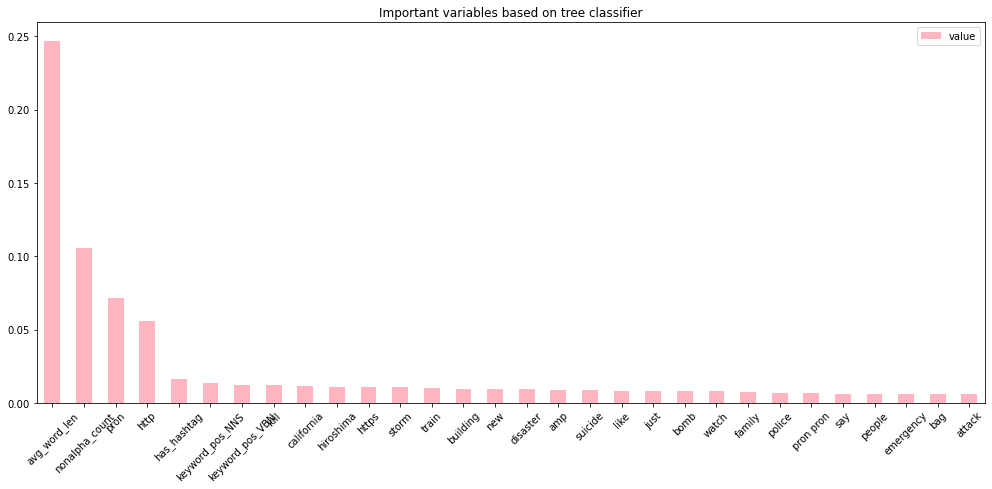

In [85]:
features_tree_.plot(kind='bar', color='lightpink', figsize=(17,7))
plt.title('Important variables based on tree classifier')
plt.xticks(rotation=45)

In [86]:
features_tree = features_tree_[features_tree_['value'] >= 0.001]

In [87]:
len(features_tree)

30

## 10. Models fitting

In [88]:
def evaluateModel(alg, X_train, Y_train, X_test, Y_test, treshold):

    #Fit the algorithm on the data
    alg.fit(X_train, Y_train)
        
    #Predict test set:
    X_test_predictions = alg.predict(X_test)
    X_test_predprob0 = alg.predict_proba(X_test)
    X_test_predprob = alg.predict_proba(X_test)[:,1]
    
    for i in range(len(X_test_predprob)):
        if X_test_predprob[i] >= treshold:
            X_test_predprob[i] = 1
        else:
            X_test_predprob[i] = 0
    
    print("AUC Score: " + str(roc_auc_score(Y_test, X_test_predprob0[:,1])))
    print("Accuracy Test: " + str(accuracy_score(Y_test, X_test_predictions)))
    print("Precision: " + str(precision_score(Y_test, X_test_predprob)))
    print("Recall: " + str(recall_score(Y_test, X_test_predprob)))

    confMatrix=confusion_matrix(Y_test, X_test_predprob)
    
    confMatrix=pd.DataFrame(confMatrix)
    
    confMatrix.columns=[['Predicted 0','Predicted 1']]
    confMatrix.index=[['True 0','True 1']]
    print('')
    print('Confusion Matrix:')
    print('')

    print(confMatrix)
    
    print('Accuracy Matrix:')
    Accuracy_Matrix=100*confMatrix.div(confMatrix.sum(axis=1),axis=0)
    print(Accuracy_Matrix)
    print('')
    return  X_test_predprob0

### 10.1. Logistic Regression

In [89]:
k = 1
preds_lr = []
log_reg = LogisticRegression(max_iter=200)
print('TRAIN set')
evaluateModel(log_reg, X_train[features_tree.index], y_train, X_train[features_tree.index], y_train, 0.5)
print('')
print('TEST set')
X_test_pred = evaluateModel(log_reg, X_train[features_tree.index], y_train, X_test[features_tree.index], y_test, 0.5)
preds_lr.append(X_test_pred[:,1])
print(' ')

TRAIN set
AUC Score: 0.756462494126573
Accuracy Test: 0.6930005629574029
Precision: 0.6816666666666666
Recall: 0.5358078602620088

Confusion Matrix:

       Predicted 0 Predicted 1
True 0        2466         573
True 1        1063        1227
Accuracy Matrix:
       Predicted 0 Predicted 1
True 0   81.145114   18.854886
True 1   46.419214   53.580786


TEST set
AUC Score: 0.7416625790244892
Accuracy Test: 0.6878283712784589
Precision: 0.6670822942643392
Recall: 0.545361875637105

Confusion Matrix:

       Predicted 0 Predicted 1
True 0        1036         267
True 1         446         535
Accuracy Matrix:
       Predicted 0 Predicted 1
True 0   79.508826   20.491174
True 1   45.463812   54.536188

 


#### Optimizing parameters - grid search

In [90]:
model = LogisticRegression(max_iter=1000)
solvers = [ 'lbfgs', 'liblinear']
penalty = ['l1', 'l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [91]:
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train[features_tree.index], y_train)

In [92]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.691126 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.684181 (0.019789) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.684494 (0.019685) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.684307 (0.019798) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 10, 'penalty': 'l1', 'solver': 'lbfgs'}
0.684244 (0.019625) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.684995 (0.020039) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.684745 (0.020160) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 1.0, 'penalty': 'l1', 'solver': 'lbfgs'}
0.685997 (0.020477) with: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
0.686685 (0.021152) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.686872 (0.021689) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 

In [93]:
preds_lr_opt = []
log_reg = LogisticRegression(C=0.1, penalty='l2', solver='liblinear', max_iter=1000)
print('TRAIN set')
evaluateModel(log_reg, X_train[features_tree.index], y_train, X_train[features_tree.index], y_train, 0.5)
print('TEST set')
X_test_pred = evaluateModel(log_reg, X_train[features_tree.index], y_train, X_test[features_tree.index], y_test, 0.5)
preds_lr_opt.append(X_test_pred[:,1])

TRAIN set
AUC Score: 0.749907533936554
Accuracy Test: 0.6946894351660724
Precision: 0.6641901931649331
Recall: 0.585589519650655

Confusion Matrix:

       Predicted 0 Predicted 1
True 0        2361         678
True 1         949        1341
Accuracy Matrix:
       Predicted 0 Predicted 1
True 0   77.690030   22.309970
True 1   41.441048   58.558952

TEST set
AUC Score: 0.7351911960401896
Accuracy Test: 0.6895796847635727
Precision: 0.6574074074074074
Recall: 0.5790010193679919

Confusion Matrix:

       Predicted 0 Predicted 1
True 0        1007         296
True 1         413         568
Accuracy Matrix:
       Predicted 0 Predicted 1
True 0   77.283193   22.716807
True 1   42.099898   57.900102



#### ROC Curver before and after tuning

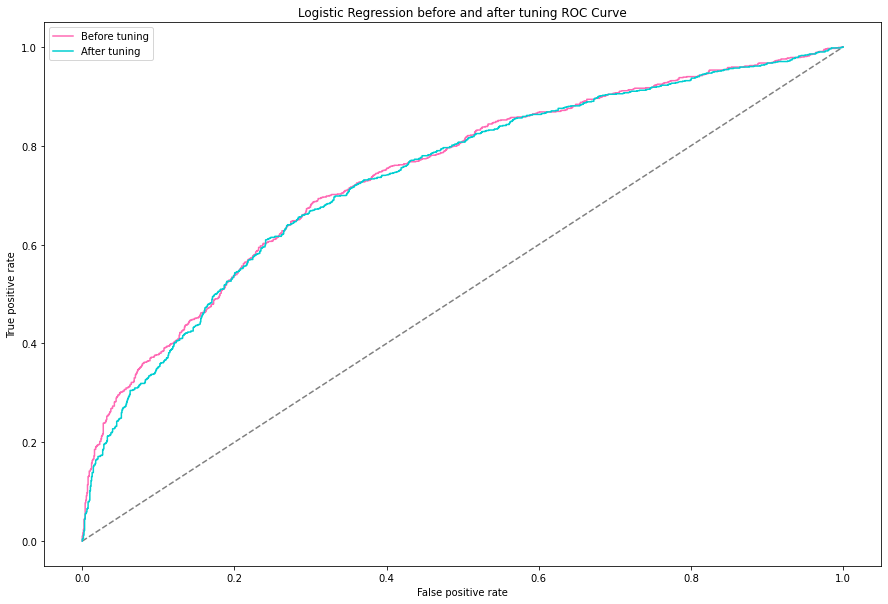

In [94]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, preds_lr[0])
fpr2, tpr2, thresholds2 = roc_curve(y_test, preds_lr_opt[0])
plt.figure(figsize=(15,10))
plt.title("Logistic Regression before and after tuning ROC Curve")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.plot(fpr1, tpr1, label='Before tuning', color='hotpink')
plt.plot(fpr2, tpr2, label='After tuning', color='darkturquoise')
plt.legend(loc="upper left")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

### 10.2. Random Forest

In [95]:
preds_rf = []
rf = RandomForestClassifier()
print('TRAIN set')
evaluateModel(rf, X_train[features_tree.index], y_train, X_train[features_tree.index], y_train, 0.5)
print('TEST set')
X_test_pred = evaluateModel(rf, X_train[features_tree.index], y_train, X_test[features_tree.index], y_test, 0.5)
preds_rf.append(X_test_pred[:,1])

TRAIN set
AUC Score: 0.9980907589976593
Accuracy Test: 0.9793582285607055
Precision: 0.9835847382431233
Recall: 0.9681222707423581

Confusion Matrix:

       Predicted 0 Predicted 1
True 0        3002          37
True 1          73        2217
Accuracy Matrix:
       Predicted 0 Predicted 1
True 0   98.782494    1.217506
True 1    3.187773   96.812227

TEST set
AUC Score: 0.72623554363294
Accuracy Test: 0.686077057793345
Precision: 0.6526195899772209
Recall: 0.5840978593272171

Confusion Matrix:

       Predicted 0 Predicted 1
True 0         998         305
True 1         408         573
Accuracy Matrix:
       Predicted 0 Predicted 1
True 0   76.592479   23.407521
True 1   41.590214   58.409786



#### Optimizing parameters - grid search

In [96]:
param_grid1 = {
    'max_depth': np.arange(3,20,1),
    'max_features': ["auto", "sqrt", "log2"]


}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid1, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train[features_tree.index],y_train)
grid_search.best_params_, grid_search.best_score_

Fitting 3 folds for each of 51 candidates, totalling 153 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 153 out of 153 | elapsed:   12.6s finished


({'max_depth': 16, 'max_features': 'auto'}, 0.7170218896442869)

In [97]:
param_grid2 = {
    'min_samples_leaf': [3, 4, 5, 10],
    'min_samples_split': [3, 8, 10, 12]
}
rf = RandomForestClassifier(max_depth=16, max_features='auto')
grid_search2 = GridSearchCV(estimator = rf, 
 param_grid = param_grid2)
grid_search2.fit(X_train[features_tree.index],y_train)
grid_search2.best_params_, grid_search2.best_score_

({'min_samples_leaf': 3, 'min_samples_split': 3}, 0.7203995454905795)

In [98]:
param_grid3= {
    'n_estimators': [100, 200, 300, 1000]
}
rf = RandomForestClassifier(max_depth=16, max_features='auto', min_samples_leaf=3, min_samples_split=3)
grid_search3 = GridSearchCV(estimator = rf, 
 param_grid = param_grid3, cv=5)
grid_search3.fit(X_train[features_tree.index],y_train)
grid_search3.best_params_, grid_search3.best_score_

({'n_estimators': 1000}, 0.7181476098617974)

In [99]:
preds_rf_opt = []
rf = RandomForestClassifier(max_depth=16, max_features='auto', min_samples_leaf=3, min_samples_split=3, n_estimators=1000)
print('TEST')
X_test_pred = evaluateModel(rf, X_train[features_tree.index], y_train, X_test[features_tree.index], y_test, 0.5)
preds_rf_opt.append(X_test_pred[:,1])

TEST
AUC Score: 0.7592875533055922
Accuracy Test: 0.6992119089316988
Precision: 0.6939313984168866
Recall: 0.5361875637104995

Confusion Matrix:

       Predicted 0 Predicted 1
True 0        1071         232
True 1         455         526
Accuracy Matrix:
       Predicted 0 Predicted 1
True 0   82.194935   17.805065
True 1   46.381244   53.618756



#### ROC Curver before and after tuning

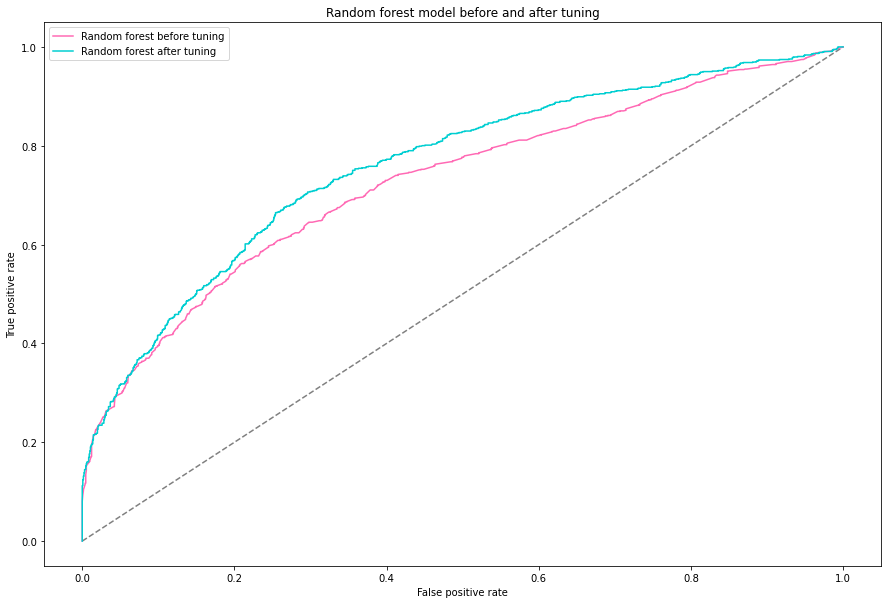

In [100]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, preds_rf[0])
fpr2, tpr2, thresholds2 = roc_curve(y_test, preds_rf_opt[0])
plt.figure(figsize=(15,10))
plt.title("Random forest model before and after tuning")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.plot(fpr1, tpr1, label='Random forest before tuning', color='hotpink')
plt.plot(fpr2, tpr2, label='Random forest after tuning', color='darkturquoise')
plt.legend(loc="upper left")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

### 10.3. XGBoost

In [101]:
preds_xgb = []
xg_boost_1 = XGBClassifier(objective= 'binary:logistic')
print('TRAIN set')
evaluateModel(xg_boost_1, X_train[features_tree.index], y_train, X_train[features_tree.index], y_train, 0.5)
X_test_pred = evaluateModel(xg_boost_1, X_train[features_tree.index], y_train, X_test[features_tree.index], y_test, 0.3)
preds_xgb.append(X_test_pred[:,1])

TRAIN set
AUC Score: 0.91793719492306
Accuracy Test: 0.8292362544567461
Precision: 0.845691382765531
Recall: 0.737117903930131

Confusion Matrix:

       Predicted 0 Predicted 1
True 0        2731         308
True 1         602        1688
Accuracy Matrix:
       Predicted 0 Predicted 1
True 0   89.865087   10.134913
True 1   26.288210   73.711790

AUC Score: 0.7507038958945991
Accuracy Test: 0.7053415061295972
Precision: 0.5646209386281589
Recall: 0.7971457696228338

Confusion Matrix:

       Predicted 0 Predicted 1
True 0         700         603
True 1         199         782
Accuracy Matrix:
       Predicted 0 Predicted 1
True 0   53.722180   46.277820
True 1   20.285423   79.714577



#### Optimizing parameters - grid search

In [102]:
param_test1 = {
 'max_depth': np.arange(3,20,1),
 'min_child_weight': np.arange(1,6,1),
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(objective= 'binary:logistic'), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train[features_tree.index],y_train)
gsearch1.best_params_, gsearch1.best_score_

C:\Users\klaud\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'max_depth': 3, 'min_child_weight': 2}, 0.7692155688044597)

In [103]:
param_test2 = {
 'gamma': [i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( max_depth=3,
 min_child_weight=2,
 objective= 'binary:logistic'), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train[features_tree.index],y_train)
gsearch2.best_params_, gsearch1.best_score_

C:\Users\klaud\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'gamma': 0.1}, 0.7692155688044597)

In [104]:
param_test3= {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( max_depth=3,
 min_child_weight=2, gamma=0.1,
 objective= 'binary:logistic'), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train[features_tree.index],y_train)
gsearch3.best_params_, gsearch3.best_score_

C:\Users\klaud\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'colsample_bytree': 0.9, 'subsample': 0.9}, 0.7704853249806801)

In [105]:
param_test4= {
'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( max_depth=3,
 min_child_weight=2, gamma=0.1, colsample_bytree = 0.9, subsample= 0.9,
 objective= 'binary:logistic'), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train[features_tree.index],y_train)
gsearch4.best_params_, gsearch4.best_score_

C:\Users\klaud\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'reg_alpha': 1}, 0.7706892460575444)

In [106]:
k = 1
preds_xgb_opt = []
xg_boost_1 = XGBClassifier(objective= 'binary:logistic', max_depth=3,
min_child_weight=2, gamma=0.1, colsample_bytree = 0.9, subsample= 0.9, reg_alpha=1)
print('TEST')
X_test_pred = evaluateModel(xg_boost_1, X_train[features_tree.index], y_train, X_test[features_tree.index], y_test, 0.5)
preds_xgb_opt.append(X_test_pred[:,1])

TEST
AUC Score: 0.7529472095681338
Accuracy Test: 0.7049036777583187
Precision: 0.6940581542351454
Recall: 0.5596330275229358

Confusion Matrix:

       Predicted 0 Predicted 1
True 0        1061         242
True 1         432         549
Accuracy Matrix:
       Predicted 0 Predicted 1
True 0   81.427475   18.572525
True 1   44.036697   55.963303



#### ROC Curver before and after tuning

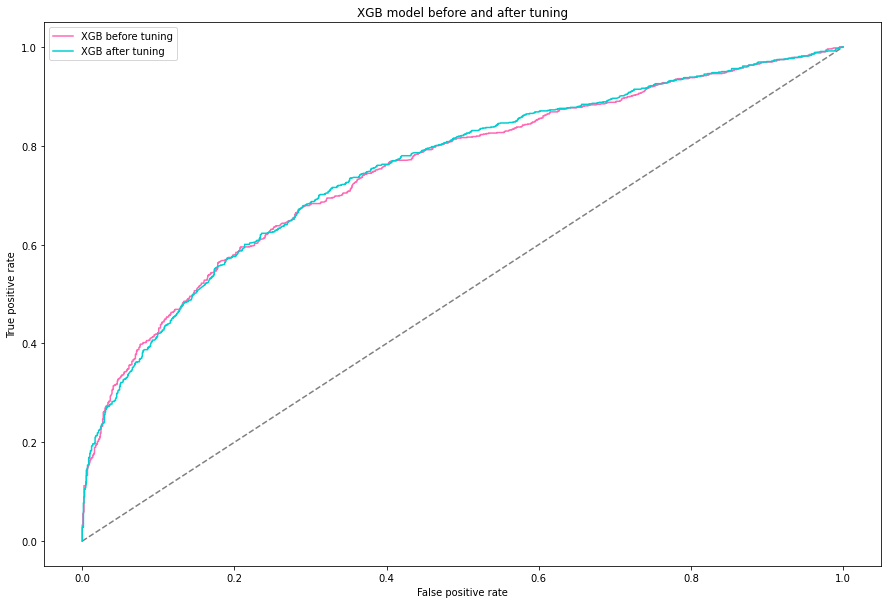

In [107]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, preds_xgb[0])
fpr2, tpr2, thresholds2 = roc_curve(y_test, preds_xgb_opt[0])
plt.figure(figsize=(15,10))
plt.title("XGB model before and after tuning")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.plot(fpr1, tpr1, label='XGB before tuning', color='hotpink')
plt.plot(fpr2, tpr2, label='XGB after tuning', color='darkturquoise')
plt.legend(loc="upper left")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

### 10.4. Models' comparison

##### ROC Curves

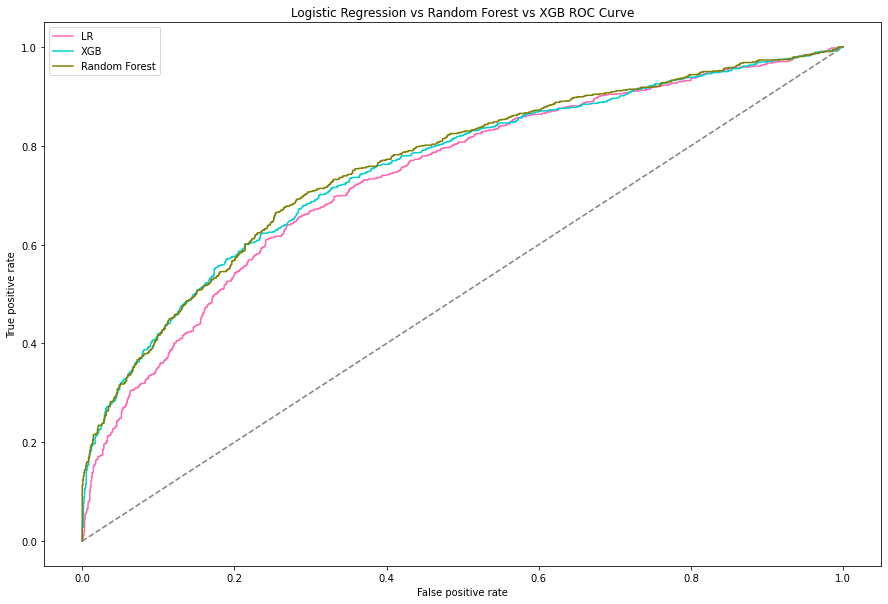

In [108]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, preds_lr_opt[0])
fpr2, tpr2, thresholds2 = roc_curve(y_test, preds_xgb_opt[0])
fpr3, tpr3, thresholds3 = roc_curve(y_test, preds_rf_opt[0])
plt.figure(figsize=(15,10))
plt.title("Logistic Regression vs Random Forest vs XGB ROC Curve")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.plot(fpr1, tpr1, label='LR', color='hotpink')
plt.plot(fpr2, tpr2, label='XGB', color='darkturquoise')
plt.plot(fpr3, tpr3, label='Random Forest', color='olive')
plt.legend(loc="upper left")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

In [109]:
print('Logistic Regression AUC: ', roc_auc_score(y_test, preds_lr_opt[0]))
print('Random Forest AUC: ', roc_auc_score(y_test, preds_rf_opt[0]))
print('XGBoost AUC: ', roc_auc_score(y_test, preds_xgb_opt[0]))

Logistic Regression AUC:  0.7351911960401896
Random Forest AUC:  0.7592875533055922
XGBoost AUC:  0.7529472095681338
